In [392]:
# Business Analysis
# Yilong Li

%matplotlib notebook
import graph_tool
import snap
import numpy as np
from pymongo import MongoClient
from matplotlib import pylab as plt
import operator
from IPython.display import HTML, display
import tabulate
from scipy import stats
import collections

In [304]:
# Database client

client = MongoClient('localhost', 27272)
db = client.test
business = db.business
reviews = db.review
users = db.users

In [329]:
# Distribution of cities
total_business = db.business.count_documents({})
total_review = db.review.count_documents({})
top_cities_by_business = list(business.aggregate([
    {'$group': {
        '_id': '$city', 
        'review_count': { '$sum' : '$review_count' }, 
        'business_count': { '$sum' : 1 }, 
    }},
    {'$sort' : {
        'business_count' : -1
    }}, 
    {'$limit' : 50}
]))

cumulative = np.cumsum([x['business_count'] for x in top_cities_by_business])
cumulative_review = np.cumsum([x['review_count'] for x in top_cities_by_business])

<IPython.core.display.Javascript object>


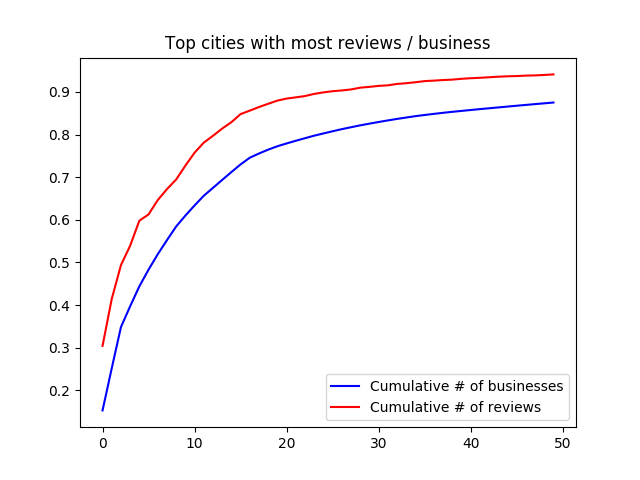

In [332]:
plt.figure()
plt.title('Top cities with most reviews / business')
plt.plot(cumulative / float(total_business), c = 'blue', label = 'Cumulative # of businesses')
plt.plot(cumulative_review / float(total_review), c = 'red', label = 'Cumulative # of reviews')
plt.legend()
plt.show()
plt.savefig('plots/cumulative-cities.pdf')

In [307]:
city_name[:10]

[u'Las Vegas',
 u'Phoenix',
 u'Toronto',
 u'Charlotte',
 u'Scottsdale',
 u'Calgary',
 u'Pittsburgh',
 u'Mesa',
 u'Montr\xe9al',
 u'Henderson']

# Score Distribution

<IPython.core.display.Javascript object>


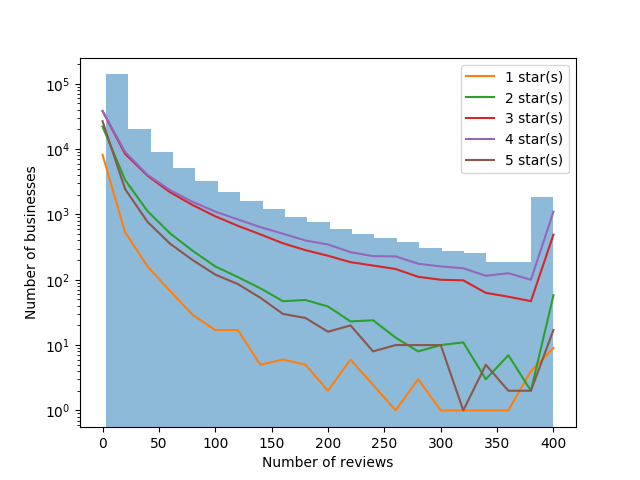

In [412]:
review_count = list(map(lambda x: min(400, x['review_count']), db.business.find({}, {'review_count' : 1})))
review_count_score = {}
for score in np.arange(1, 5.5, 1):
    review_count_score[score] = list(map(lambda x: min(400, x['review_count']), db.business.find({ 'stars' : { '$gte': score, '$lt' : score + 1 } }, {'review_count' : 1})))

fig, ax1= plt.subplots()
ax1.hist(review_count, bins=20, alpha=0.5, linestyle='-')
for score in np.arange(1, 5.5, 1):
    data_array = (np.array(sorted(review_count_score[score])) / 20).astype(int) * 20
    d_items = collections.Counter(data_array).items()
    data = zip(*sorted(d_items))
    ax1.plot(data[0], data[1], linestyle='-', label=str(int(score)) + " star(s)")
ax1.set_yscale('log')
ax1.set_xlabel('Number of reviews')
ax1.set_ylabel('Number of businesses')
ax1.legend()
plt.savefig('plots/reviews-score-business.pdf')
plt.show()


In [308]:
score_count = list(db.business.aggregate([
    {
        '$group': {
            '_id': '$stars', 
            'count': { '$sum' : 1 },
        }
    },
    {
        '$sort': {
            '_id' : 1
        }
    }
]))

score_review_count = list(db.review.aggregate([
    {
        '$group': {
            '_id': '$stars', 
            'count': { '$sum' : 1 },
        }
    },
    {
        '$sort': {
            '_id' : 1
        }
    }
]))

stars_business, count_by_stars_business = [x['_id'] for x in score_count], [x['count'] for x in score_count]
stars_review, count_by_stars_review = [x['_id'] for x in score_review_count], [x['count'] for x in score_review_count]

In [361]:
score_count = list(db.business.aggregate([
    {
        '$match' : { 'review_count' : { '$gte' : 0 }} 
    },
    {
        '$group': {
            '_id': '$stars', 
            'count': { '$sum' : 1 },
            'avg': { '$avg' : '$review_count' },
            'sigma': { '$stdDevPop': '$review_count' }
        }
    },
    {
        '$sort': {
            '_id' : 1
        }
    }
]))

score_review_count = list(db.review.aggregate([
    {
        '$group': {
            '_id': '$stars', 
            'count': { '$sum' : 1 },
        }
    },
    {
        '$sort': {
            '_id' : 1
        }
    }
]))

stars_business, count_by_stars_business = [x['_id'] for x in score_count], [x['count'] for x in score_count]
stars_review, count_by_stars_review = [x['_id'] for x in score_review_count], [x['count'] for x in score_review_count]
stars_avg, stars_sigma = [x['avg'] for x in score_count], [x['sigma'] for x in score_count]

<IPython.core.display.Javascript object>


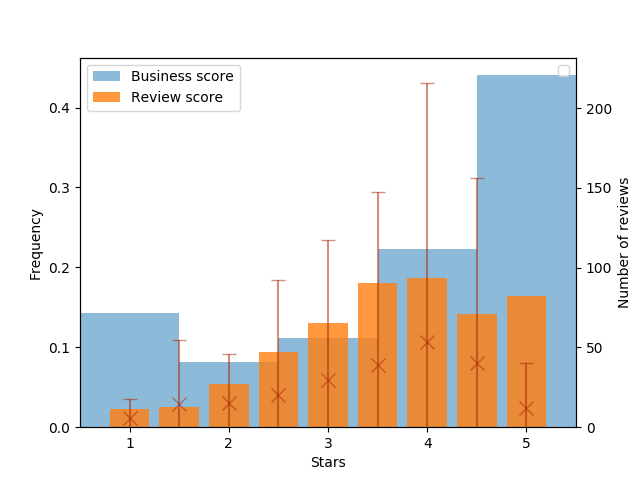

In [411]:
fig, ax1 = plt.subplots()
ax1.bar(stars_review, np.array(count_by_stars_review) / float(total_review), width=1, alpha=0.5, label='Business score', align='center')
ax1.bar(stars_business, np.array(count_by_stars_business) / float(np.sum(np.array(count_by_stars_business))), alpha=0.8, width=0.4, label='Review score', align='center')
ax1.legend()
ax1.set_xlim(0.5, 5.5)
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Stars")

ax2 = ax1.twinx()
ax2.errorbar(stars_business, stars_avg, stars_sigma, linestyle='None', alpha=0.5, capsize=5, markersize=10, color='#aa2200', marker='x')
ax2.set_ylim(0)
ax2.set_ylabel("Number of reviews")

plt.legend()
plt.show()
plt.savefig('plots/distribution-of-scores.pdf')

<IPython.core.display.Javascript object>


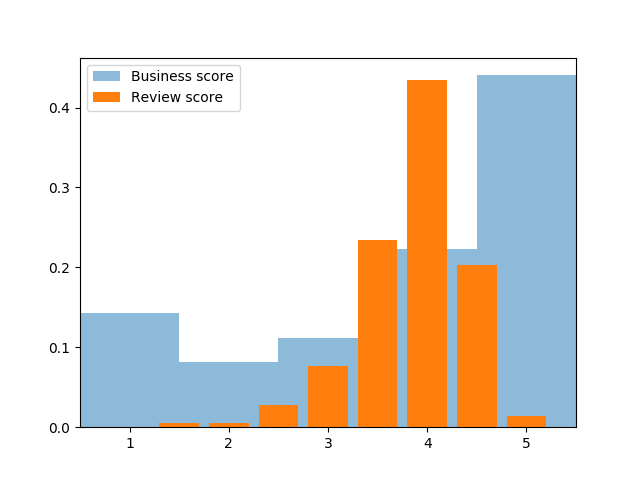

In [338]:
plt.figure()
plt.bar(stars_review, np.array(count_by_stars_review) / float(total_review), width=1, alpha=0.5, label='Business score', align='center')
plt.bar(stars_business, np.array(count_by_stars_business) / float(np.sum(np.array(count_by_stars_business))), width=0.4, label='Review score', align='center')
plt.xlim(0.5, 5.5)
plt.legend()
plt.show()
# plt.savefig('plots/distribution-of-scores.pdf')

<IPython.core.display.Javascript object>


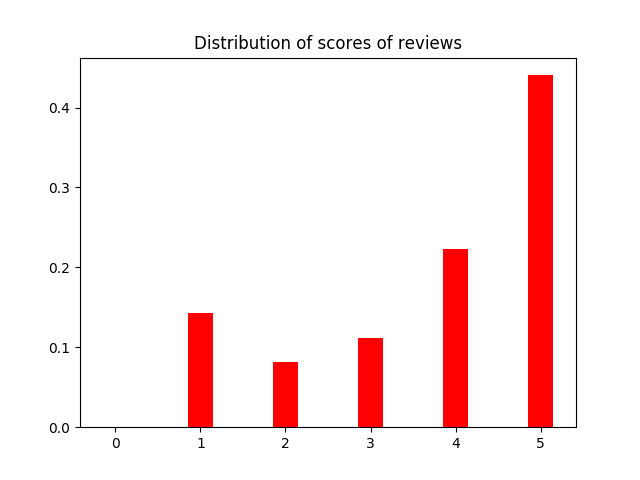

In [312]:
plt.figure()
plt.title('Distribution of scores of reviews')
plt.bar(stars_review, np.array(count_by_stars_review) / float(total_review), width=0.3, color='red', label='Distribution of business scores', align='center')
plt.show()

In [263]:
# Distribution of business scores, grouped by cities

top_cities = [u'Las Vegas',
 u'Phoenix',
 u'Toronto',
 u'Charlotte',
 u'Scottsdale',
 u'Calgary',
 u'Pittsburgh',
 u'Mesa',
 u'Montr\xe9al',
 u'Henderson']

distribution = list(db.business.aggregate([
    {
        '$match' : { 'city' : { '$in' : top_cities } , 'review_count' : { '$gte' : 20 } }
    },
    {
        '$group': {
            '_id': { 'city' : '$city',  'stars': '$stars' } , 
            'count': { '$sum' : 1 },
        }
    },
    {
        '$group': {
            '_id': '$_id.city', 
            'star_count': { '$push' : { 'stars' : '$_id.stars', 'count' : '$count' } }, 
            'total_business': { '$sum' : '$count' }
        }
    }
]))

<IPython.core.display.Javascript object>


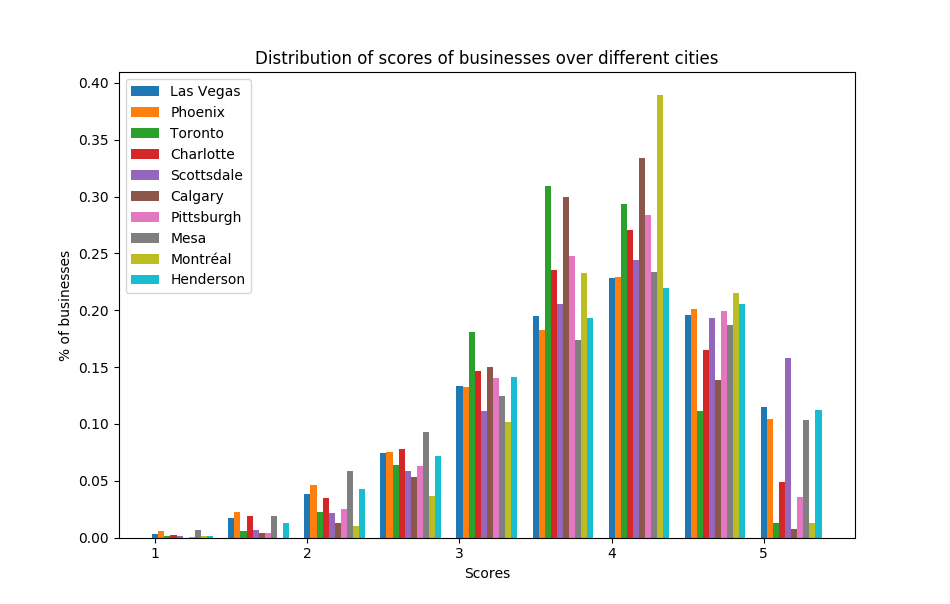

In [292]:
cmap=plt.cm.get_cmap(plt.cm.autumn)

plt.figure()
plt.title('Distribution of scores of businesses over different cities')
width = 0.04
idx = 0

for city in top_cities:
    kv = [kv for kv in distribution if kv['_id'] == city][0]
    city = kv['_id']
    sorted_star_count = sorted(kv['star_count'], key=lambda x: x['stars'])
    count = np.array([x['count'] for x in sorted_star_count]) / float(kv['total_business'])
    stars = np.array([x['stars'] for x in sorted_star_count])
    plt.bar(stars + width * idx, count, width, label=city)
    idx += 1
plt.legend()
plt.xlabel('Scores')
plt.ylabel('% of businesses')
plt.show()


In [202]:
business_in_top_cities = list(map(lambda x: x['business_id'], db.business.aggregate([
    {
        '$match' : { 'city' : { '$in' : top_cities } }
    },
    {
        '$project': {
            "_id": 0,
            "business_id": 1
        }
    }
])))

In [212]:
len(business_in_top_cities)

115044

In [265]:
# Distribution of number of reviews, grouped by cities

top_cities = [u'Las Vegas',
 u'Phoenix',
 u'Toronto',
 u'Charlotte',
 u'Scottsdale',
 u'Calgary',
 u'Pittsburgh',
 u'Mesa',
 u'Montr\xe9al',
 u'Henderson']

distribution_review = list(db.business.aggregate([
    {
        '$match' : { 'city' : { '$in' : top_cities } , 'review_count' : { '$gte' : 20 } }
    },
    {
        '$group': {
            '_id': '$city', 
            'review_count': { '$push' : '$review_count' },
            'total_business': { '$sum' : 1 }
        }
    }
]))

<IPython.core.display.Javascript object>


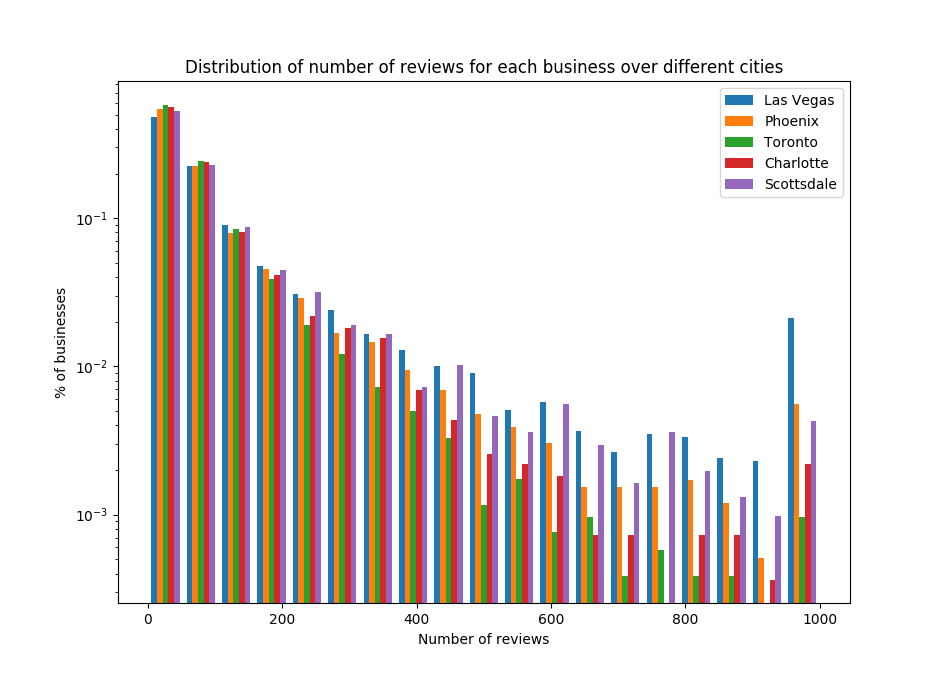

[ 20  28 242 ... 108  76  20]
11661 1693031
[ 63 277 230 ... 146 132  38]
5882 566245
[146  23  25 ... 127  71 211]
5206 381976
[ 85 103  68 ...  27  24 100]
2749 228005
[234  28  23 ...  41  44  25]
3043 307954


In [291]:
cmap=plt.cm.get_cmap(plt.cm.autumn)

plt.figure()
plt.title('Distribution of number of reviews for each business over different cities')
width = 0.05
idx = 0
cities = []
counts = []
offsets = []
bins = np.linspace(0, 1000, 20)
for city in top_cities[:5]:
    kv = [kv for kv in distribution_review if kv['_id'] == city][0]
    cities.append(kv['_id'])
    count = np.array(kv['review_count'])
    print count
    print len(count), sum(count)
    # count = count / float(sum(count))
    offset = np.zeros_like(count) + 1. / len(count)
    counts.append(np.clip(count, bins[0], bins[-1]))
    offsets.append(offset)
    idx += 1
plt.hist(counts, bins=bins, label=cities, stacked=False, weights=offsets)
plt.yscale('log')
plt.xlabel('Number of reviews')
plt.ylabel('% of businesses')
plt.legend()
plt.show()
